Вирішити задачу: за підсумками іспитів з 37 студентів відмінну оцінку з математики мали 15 студентів,
з фізики - 16, з хімії - 19, з математики та фізики - 7, з математики та хімії - 9, з фізики та хімії - 6,
з усіх трьох дисциплін - 4. Скільки студентів отримали хоча б по одній відмінній оцінці?
Роботу виконайте у середовищі Jupyter Notebook

32 студента отримали як мінімум по одній відмінній оцінці


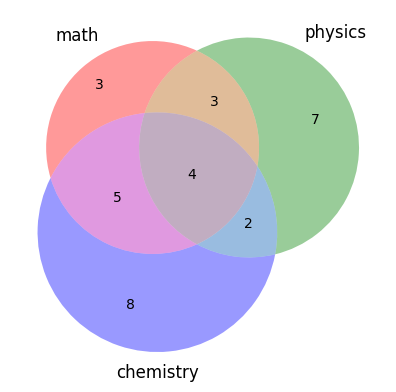

In [5]:
import matplotlib.pyplot as plt
from matplotlib_venn import venn3, venn3_circles

id_student = 0

grade = {'matan' : 15,
         'fithic' : 16,
         'chemic' : 19}

intersection = { 'm_f_c' : 4,
                 'm_f' : 7,
                 'm_c' : 9,
                 'f_c' : 6 }

result_id = {'matan' : [],
             'fithic' : [],
             'chemic' : []}

while intersection['m_f_c'] > 0:
    intersection['m_f_c'] -= 1
    intersection['m_f'] -= 1
    intersection['m_c'] -= 1
    intersection['f_c'] -= 1
    result_id['matan'].append(id_student)
    grade['matan'] -= 1
    result_id['fithic'].append(id_student)
    grade['fithic'] -= 1
    result_id['chemic'].append(id_student)
    grade['chemic'] -= 1
    id_student += 1

while intersection['m_f'] > 0:
    intersection['m_f'] -= 1
    result_id['matan'].append(id_student)
    grade['matan'] -= 1
    result_id['fithic'].append(id_student)
    grade['fithic'] -= 1
    id_student += 1

while intersection['m_c'] > 0:
    intersection['m_c'] -= 1
    result_id['matan'].append(id_student)
    grade['matan'] -= 1
    result_id['chemic'].append(id_student)
    grade['chemic'] -= 1
    id_student += 1

while intersection['f_c'] > 0:
    intersection['f_c'] -= 1
    result_id['fithic'].append(id_student)
    grade['fithic'] -= 1
    result_id['chemic'].append(id_student)
    grade['chemic'] -= 1
    id_student += 1

while grade['matan'] > 0:
    grade['matan'] -= 1
    result_id['matan'].append(id_student)
    id_student += 1

while grade['fithic'] > 0:
    grade['fithic'] -= 1
    result_id['fithic'].append(id_student)
    id_student += 1

while grade['chemic'] > 0:
    grade['chemic'] -= 1
    result_id['chemic'].append(id_student)
    id_student += 1

print(f"{id_student} студента отримали як мінімум по одній відмінній оцінці")    
    
venn3([set(result_id['matan']), set(result_id['fithic']), set(result_id['chemic'])], ('math', 'physics', 'chemistry'))
plt.show()